# Projeto 1

## Tarefa 1

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

pi = math.pi

In [2]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

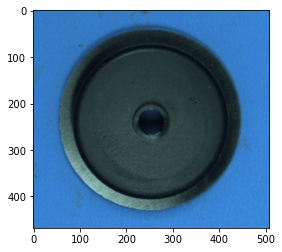

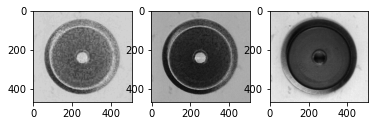

H max: 112
H min: 78
S max: 255
S min: 51
V max: 237
V min: 10


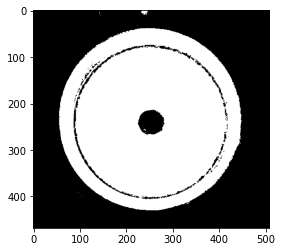

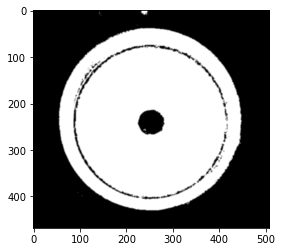

Number of objects detected: 143

Area: 6.0

Area: 4.0

Area: 167.5

Area: 4.0

Area: 29.5

Area: 0.0

Area: 0.0

Area: 2.0

Area: 98.5

Area: 18.5

Area: 2.0

Area: 0.0

Area: 76.5

Area: 5.5

Area: 5.5

Area: 84.5

Area: 2.0

Area: 30.5

Area: 2.0

Area: 2.0

Area: 2.0

Area: 0.0

Area: 2.0

Area: 2.0

Area: 96.5

Area: 4.0

Area: 2.0

Area: 12.5

Area: 41.0

Area: 2.0

Area: 26.0

Area: 5.5

Area: 2.0

Area: 2.0

Area: 13.5

Area: 2.0

Area: 10.0

Area: 2.0

Area: 0.0

Area: 11.5

Area: 2.0

Area: 136.5

Area: 4.0

Area: 2.0

Area: 0.0

Area: 34.0

Area: 5.5

Area: 0.0

Area: 72.0

Area: 23.5

Area: 2.0

Area: 2.0

Area: 2.0

Area: 54.5

Area: 0.0

Area: 14.5

Area: 4.0

Area: 0.0

Area: 4.0

Area: 4.0

Area: 12.0

Area: 12.5

Area: 0.0

Area: 8.0

Area: 21.0

Area: 2.0

Area: 2.0

Area: 2394.0

Area: 67.5

Area: 2.0

Area: 7.0

Area: 59.0

Area: 2.0

Area: 8.0

Area: 7.0

Area: 5.5

Area: 1352.5

Area: 11.5

Area: 0.0

Area: 2.0

Area: 9.5

Area: 2.0

Area: 2.0

Area: 13.0

Area: 42

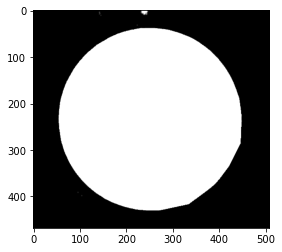

Nro de blobs:  1
Blob_ 1 : X=  250.7298126220703  Y=  234.35699462890625  size= 152874.98614312708  ang= -1.0


In [22]:

fig = cv2.imread("OK/Fig_OK_15.jpg")
#fig = cv2.imread("NOK_superficie/Fig_NOK_Superf_03.jpg")
#fig = cv2.imread("NOK_borda/Fig_NOK_12.jpg")

#plt.imshow(fig)
#plt.show()


(h,w,c) = fig.shape

figRGB = cv2.cvtColor(fig,cv2.COLOR_BGR2RGB)
plt.imshow(figRGB)
plt.show()


img_hsv = cv2.cvtColor(fig, cv2.COLOR_BGR2HSV)
(canal_H, canal_S, canal_V) = cv2.split(img_hsv)
plt.figure("Hue")
plt.subplot(1,3,1)
plt.imshow(canal_H,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(canal_S,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(canal_V,cmap='gray')
plt.show()

print("H max:",np.max(canal_H))
print("H min:", np.min(canal_H))
print("S max:",np.max(canal_S))
print("S min:", np.min(canal_S))
print("V max:",np.max(canal_V))
print("V min:", np.min(canal_V))

#print(canal_H)


#Separando as matrizes
[B,G,R] = cv2.split(figRGB)
#plt.imshow(G, cmap='gray')
#plt.show()

#Binarizando a imagem para fazer o cálculo
#fig_bin = np.where((B>120), 255, 0).astype(np.uint8)
#plt.imshow(fig_bin, cmap='gray')
#plt.show()

#gamma = adjust_gamma(canal_S, 5)
#plt.imshow(gamma,cmap='gray')
#plt.show()
#(canal_H>101)&(canal_V<170)
#&(canal_V<200) & (canal_S<130)
thresh = np.where((((canal_S<160))),255,0).astype(np.uint8)
plt.imshow(thresh,cmap='gray')
plt.show()


dst = cv2.GaussianBlur(thresh,(3,3),cv2.BORDER_DEFAULT)
plt.imshow(dst,cmap='gray')
plt.show()

#circles = cv2.HoughCircles(fig, cv2.HOUGH_GRADIENT,1,1)
#print(circles)

contours,hierarchy = cv2.findContours(thresh, 1, 2)
print("Number of objects detected:", len(contours))

#contours[-5] possui o contorno do circulo na figura 1

fig_contor = fig

for c in contours:
    hull = cv2.convexHull(c)
    #img = cv2.drawContours(fig,[hull],0,(255,255,0),2)
    area = cv2.contourArea(c)
    #print("\nArea:",area)
    
    print("\nArea:",area)
    if (area>80000):
        img = cv2.drawContours(dst,[hull],0,(255,255,255),thickness=cv2.FILLED)
        #equi_diameter = np.sqrt(4*area/np.pi)
        #print("Diameter:", equi_diameter)
        #(x,y),radius = cv2.minEnclosingCircle(c)
        #center = (int(x),int(y))
        #radius = int(radius)
        #cv2.circle(img,center,radius,(156,156,156),thickness=cv2.FILLED)
        #print("Radius:",radius)
        #cv2.circle(img,center,3,(255,255,0),1)
        #img = cv2.drawContours(dst,[hull],0,(255,255,0),3)
        #img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #cinzas = np.sum(img_RGB == [156,156,156])
        #print("Pixels cinzas:", cinzas)
        #plt.imshow(img_RGB)
        #ellipse = cv2.fitEllipse(c)
        #(xE, yE), (MA, ma), angle = cv2.fitEllipse(c)
        #print("MA:", MA)
        #print("ma:", ma)
        #A = pi * MA * ma
        #print("Area elipse:", A)
        #cv2.ellipse(img,ellipse, (60,0,0), 3)
        #fig_contor = cv2.drawContours(img,[hull],0,(156,156,156), 2)
        img = cv2.drawContours(thresh,[hull],0,(255,255,255),1)
        area = cv2.contourArea(c)
        #print("\nArea:",area)
        areas[i] = area

        #Encontrando o diâmetro
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius*2)
        diametros[i] = (radius*esteira_mm)/508

        #Encontrando a relação A/B
        (xE, yE), (MA, ma), angle = cv2.fitEllipse(c)
        diametros_maiores[i] = (MA*esteira_mm)/508
        diametros_menores[i] = (ma*esteira_mm)/508
        relacao[i] = diametros_menores[i]/diametros_maiores[i]
        #print("MA:", MA)
        #print("ma:", ma)
        
        fig_contor = img
        

print("Teste")
plt.imshow(fig_contor, cmap='gray')
plt.show()

#ret2, fig_contor2 = cv2.threshold(fig_contor,250,255,0)
#plt.imshow(fig_contor2, cmap='gray')
#plt.show()

#fig_contor3 = cv2.cvtColor(fig_contor,cv2.COLOR_BGR2RGB)
#plt.imshow(fig_contor3)
#plt.show()


detector = blob_detec()

# Detect blobs
KP = detector.detect(fig_contor)
print("Nro de blobs: ",len(KP))
# List parameters (X,Y,size,ang) of each detected keypoints
img1_text = fig_contor
i=1
for KPi in KP:
    print("Blob_", i, ": X= ", KPi.pt[0], " Y= ", KPi.pt[1], " size=", KPi.size**2, " ang=", KPi.angle)
    img1_text = cv2.putText(img1_text, str(i), (int(KPi.pt[0]),int(KPi.pt[1])), cv2.FONT_HERSHEY_PLAIN, 1,(255,0,0))
    i=i+1

#plt.imshow(img1_text, cmap='gray')
#plt.show()



#Green para borda
#HUE e SAT para a superfície


#Canal v - rugosidade
#Canal s - borda

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt


path="OK\*.jpg"    #Replace with your folder 
#path("OK\*.jpg") 
k=glob.glob(path)
images=[cv2.imread(images) for images in glob.glob(path)]

print(len(images))     #number of images in folder
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    #cv2.imshow("images",images[i])
    #cv2.waitKey(0)

15


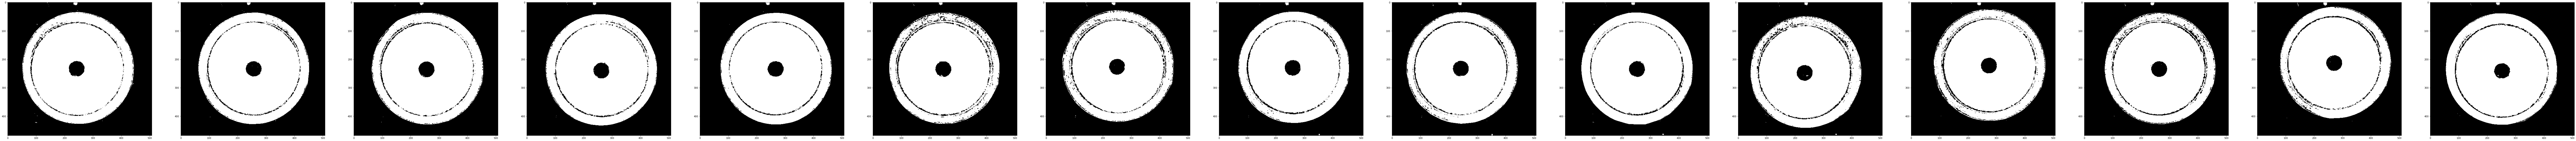


Áreas
Média: 118277.3
Máx 119693.0
Min: 116801.5
Diametros
Média: 49.65376368249504
Máx 49.95041258919306
Min: 49.34338211293757
Diametros maiores:
Média: 49.55065801825737
Máx 49.852003262737604
Min: 49.315541184793304
Diametros menores:
Média: 49.79151309756783
Máx 50.04714214895654
Min: 49.402458311065914
Relação A/B: [1.0081628664172169, 1.0078161508137462, 1.0056618522813336, 1.0043959209916824, 1.0076491120825768, 1.001430071732341, 1.0038339109890115, 1.0066623606544864, 1.005287465794984, 1.0039143639863475, 1.0022092707581953, 1.0044031872613102, 1.0038224972762055, 1.0066830781916274, 1.000984897455117]


In [89]:
import glob
import cv2
import matplotlib.pyplot as plt

#path="NOK_borda\*.jpg"
#path="NOK_tamanho_forma\*.jpg"
path="OK\*.jpg" #Replace with your folder 
#path("OK\*.jpg") 
k=glob.glob(path)
images=[cv2.imread(images) for images in glob.glob(path)]

print(len(images))     #number of images in folders

plt.figure(figsize=(200, 800)) 

esteira_mm = 65

areas = [0]*len(images)
diametros = [0]*len(images)
diametros_maiores = [0]*len(images)
diametros_menores = [0]*len(images)
relacao = [0]*len(images)


for i in range(len(images)):
    #plt.imshow(images[i])
    #plt.show()
    #cv2.imshow("images",images[i])
    #cv2.waitKey(0)
    
    img_hsv = cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)
    (canal_H, canal_S, canal_V) = cv2.split(img_hsv)
    
    thresh = np.where((((canal_S<160))),255,0).astype(np.uint8)
    
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    #print("\nNumber of objects detected:", len(contours))

    fig_contor = images[i]

    for c in contours:
        hull = cv2.convexHull(c)
        area = cv2.contourArea(c)
        #img = cv2.drawContours(thresh,[hull],0,(156,156,156),1)
        #print("\nArea:",area)
        if (area> 116800):
            img = cv2.drawContours(thresh,[hull],0,(255,255,255),1)
            area = cv2.contourArea(c)
            #print("\nArea:",area)
            areas[i] = area
            equi_diameter = np.sqrt(4*area/np.pi)
            
            #Encontrando o diâmetro
            (x,y),radius = cv2.minEnclosingCircle(c)
            center = (int(x),int(y))
            radius = int(radius*2)
            diametros[i] = (equi_diameter*esteira_mm)/508
            
            #Encontrando a relação A/B
            (xE, yE), (MA, ma), angle = cv2.fitEllipse(c)
            diametros_maiores[i] = (MA*esteira_mm)/508
            diametros_menores[i] = (ma*esteira_mm)/508
            relacao[i] = diametros_menores[i]/diametros_maiores[i]
            #print("MA:", MA)
            #print("ma:", ma)
            
            fig_contor = img
            
            
            
    plt.subplot(1,len(images),i+1)
    plt.imshow(fig_contor,cmap='gray')

    
plt.show()
    
print("\nÁreas")            
print("Média:",np.mean(areas))
print("Máx",np.max(areas))
print("Min:", np.min(areas))
print("Diametros")
print("Média:",np.mean(diametros))
print("Máx",np.max(diametros))
print("Min:", np.min(diametros))
print("Diametros maiores:")
print("Média:",np.mean(diametros_maiores))
print("Máx",np.max(diametros_maiores))
print("Min:", np.min(diametros_maiores))
print("Diametros menores:")
print("Média:",np.mean(diametros_menores))
print("Máx",np.max(diametros_menores))
print("Min:", np.min(diametros_menores))
print("Relação A/B:", relacao)

In [47]:
def blob_detec():
    #Blob
    # Set up the detector with default parameters.
    params = cv2.SimpleBlobDetector_Params()
    # Set blob color (0=black, 255=white)
    params.filterByColor = True
    params.blobColor = 255
    # Filter by Area
    params.filterByArea = False
    # params.minArea = 1
    # #params.maxArea = 20000
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8
    #params.maxCircularity = 1
    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.5
    #params.maxConvexity = 0.9
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.5
    #params.maxInertiaRatio = 1
    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create(params)
    return detector
